In [39]:
# import necessary importa
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

from urllib.parse import quote_plus as urlquote

In [40]:
df_combined = pd.read_csv('Data/tmdb_results_combined.csv.gz')
df_combined.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2009.0,PG


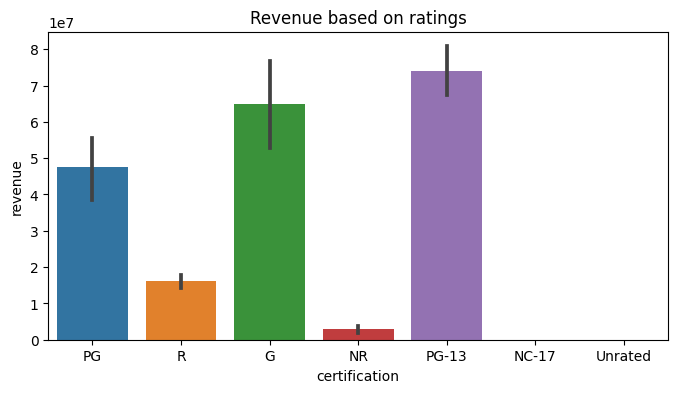

In [41]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(data=df_combined, x='certification', y='revenue', ci=55, ax=ax)
plt.title("Revenue based on ratings");

In [42]:
list_of_ratings = df_combined['certification'].value_counts().index

In [44]:
my_dfs = {}
for i in list_of_ratings:
    my_dfs[i] = df_combined.loc[df_combined['certification']==i, 'revenue']    

In [45]:
my_dfs.keys()

dict_keys(['R', 'PG-13', 'NR', 'PG', 'G', 'NC-17', 'Unrated'])

# Do the MPAA ratings of a movie affect how much revenue the movie generates?

 - $H_0:$ The MPAA ratings have no effect how much revenue the movie generates.
 - $H_1:$ The MPAA rating does effect how much revenue the movie makes.
 
 Data Type : Numeric (Revenue)
 
 Samples: More than 2 samples/groups
 
 Test: ANOVA and/or Tukey
 
 Assumptions: 
    - No significant outliers
    - Equal variance
    - Normality

# Remove outliers

In [74]:
# Test an example before running on all Series
# temp = my_dfs['R']
# zscores = stats.zscore(temp)
# outliers = np.abs(zscores) > 3
# temp_clean = temp[outliers == False]
# temp_clean

In [57]:
def is_outlier(temp): # removes outliers
    zscores = stats.zscore(temp)
    outliers = np.abs(zscores) > 3
    temp_clean = temp[outliers == False]
    print('Number of outliers : ', outliers.sum())
    
    return temp_clean

In [75]:
# Test the above function
# x = is_outlier(my_dfs['PG-13'])
# x

In [64]:
cleaned_data = {} # print message when not true
for i, df in my_dfs.items():
    temp = is_outlier(df)
    if (len(temp) > 4):
        cleaned_data[i] = temp

Number of outliers :  10
Number of outliers :  4
Number of outliers :  2
Number of outliers :  4
Number of outliers :  0
Number of outliers :  0
Number of outliers :  0


# Check for normality

In [70]:
for i,data in cleaned_data.items():
    result = stats.shapiro(data)
    print('For ratings ', i, ' the result from the shaprio test is', result.pvalue)
    if(result.pvalue < .05):
        print("Significant")
        print("The number of samples we have is : ", len(data), "\n")
    else:
        print("Not Significant\n")

For ratings  R  the result from the shaprio test is 3.1547373262053816e-34
Significant
The number of samples we have is :  412 

For ratings  PG-13  the result from the shaprio test is 3.3226987585396027e-16
Significant
The number of samples we have is :  164 

For ratings  NR  the result from the shaprio test is 8.088910536394392e-16
Significant
The number of samples we have is :  60 

For ratings  PG  the result from the shaprio test is 8.753607616540648e-09
Significant
The number of samples we have is :  54 

For ratings  G  the result from the shaprio test is 0.00012857618276029825
Significant
The number of samples we have is :  26 

For ratings  NC-17  the result from the shaprio test is 1.0
Not Significant



Even for the tests have a significant p-value, which means we failed the normality test, we can still proceed as planned because we have more then 15 samples in each group.

# Equal Variance

In [72]:
result = stats.levene(*cleaned_data.values())
print(result)

LeveneResult(statistic=35.079343702736175, pvalue=3.818335937631552e-32)


Because we have a significant p-value we must conclude that our data is not equally variant.

# Final Test

In [73]:
result = stats.kruskal(*cleaned_data.values())
print(result)

KruskalResult(statistic=122.26821191002445, pvalue=1.0379966950838584e-24)


Because we have a significant p-value we reject our null hypothesis and support our alternative hypthesis that "The MPAA rating does effect how much revenue the movie generates.